# JPEG Compression

### 1. Importing Libraries

In [80]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color
from scipy.fftpack import dct, idct

### 2. Loading and Displaying the Original Image

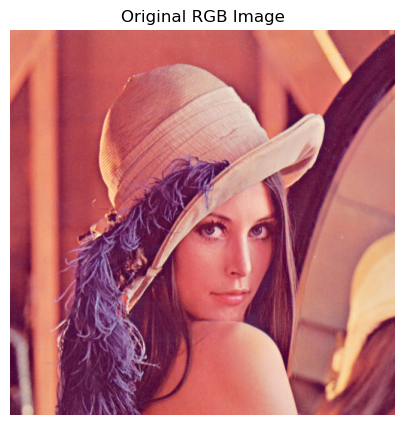

Image shape: (512, 512, 3)


In [81]:
img_url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'

img = io.imread(img_url)

img = img.astype(np.float32)

plt.figure(figsize=(5, 5))
plt.imshow(img.astype(np.uint8))
plt.title("Original RGB Image")
plt.axis('off')
plt.show()

print(f"Image shape: {img.shape}")

### 3. Converting RGB to YCb using opencv to split the image into Luminance (Y), Blue chrominance (Cb), Red Chrominance (Cr). Then visualizing each channel

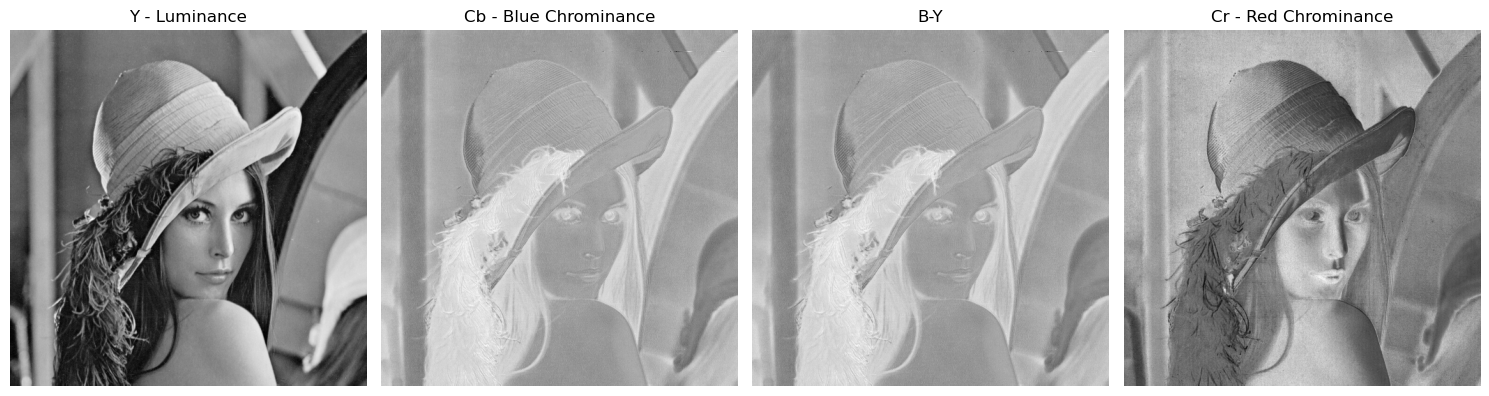

In [82]:
B = img[:, :, 2]
img_ycbcr = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2YCrCb).astype(np.float32)

Y, Cr, Cb = cv2.split(img_ycbcr)

Difference = B - Y 

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
channels = [Y, Cb, Difference, Cr]
titles = ['Y - Luminance', 'Cb - Blue Chrominance', 'B-Y', 'Cr - Red Chrominance']

for ax, channel, title in zip(axes, channels, titles):
    ax.imshow(channel, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

### 4. Chroma Subsampling (4:2:0)

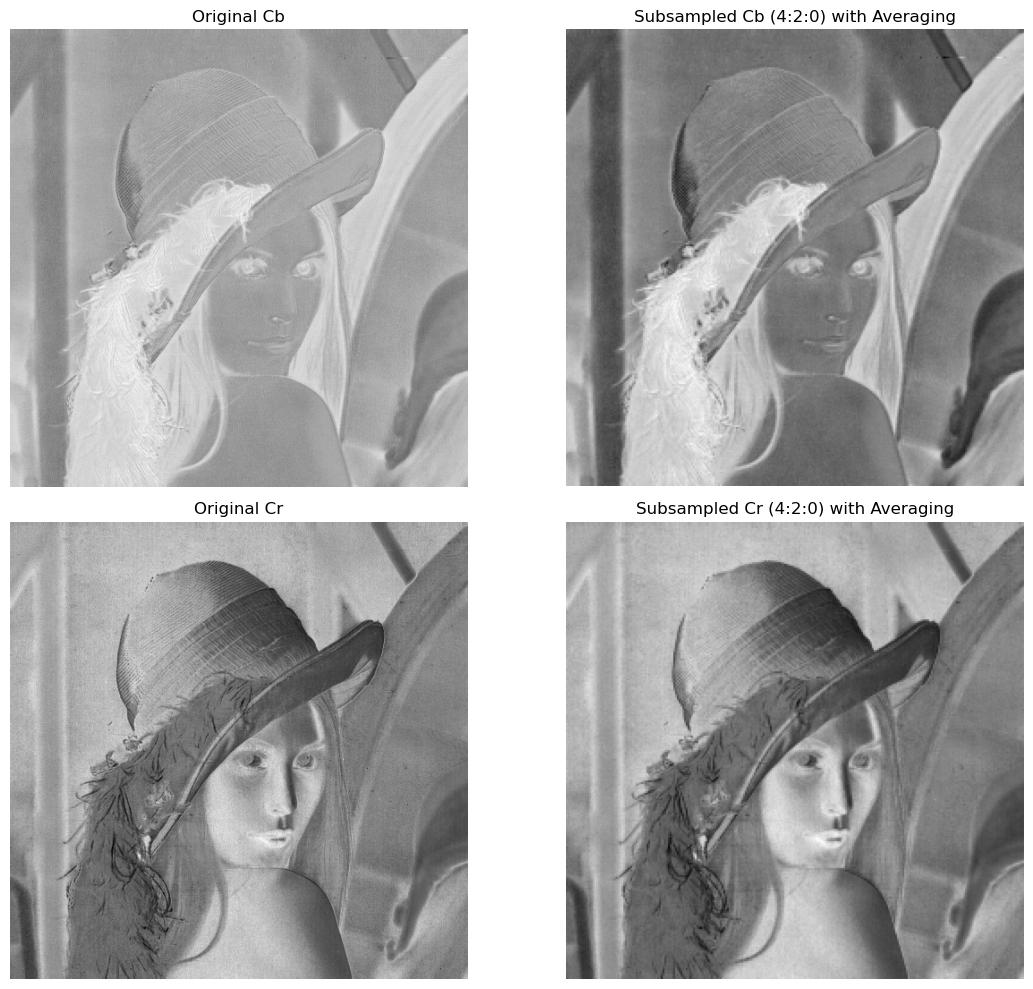

Original Cb shape: (512, 512) → Subsampled Cb shape: (256, 256)
Original Cr shape: (512, 512) → Subsampled Cr shape: (256, 256)


In [83]:
def chroma_subsample_420_avg(channel):

    h, w = channel.shape

    h_even = h - h % 2
    w_even = w - w % 2
    
    channel_cropped = channel[:h_even, :w_even]

    subsampled = (channel_cropped[0::2, 0::2] + channel_cropped[1::2, 0::2] +
                  channel_cropped[0::2, 1::2] + channel_cropped[1::2, 1::2]) / 4
    
    return subsampled

Cb_subsampled_avg = chroma_subsample_420_avg(Cb)
Cr_subsampled_avg = chroma_subsample_420_avg(Cr)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(Cb, cmap='gray')
axes[0, 0].set_title("Original Cb")
axes[0, 0].axis('off')

axes[0, 1].imshow(Cb_subsampled_avg, cmap='gray')
axes[0, 1].set_title("Subsampled Cb (4:2:0) with Averaging")
axes[0, 1].axis('off')

axes[1, 0].imshow(Cr, cmap='gray')
axes[1, 0].set_title("Original Cr")
axes[1, 0].axis('off')

axes[1, 1].imshow(Cr_subsampled_avg, cmap='gray')
axes[1, 1].set_title("Subsampled Cr (4:2:0) with Averaging")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original Cb shape: {Cb.shape} → Subsampled Cb shape: {Cb_subsampled_avg.shape}")
print(f"Original Cr shape: {Cr.shape} → Subsampled Cr shape: {Cr_subsampled_avg.shape}")

### 5. Dividing the image into 8x8 blocks and displaying the first block.

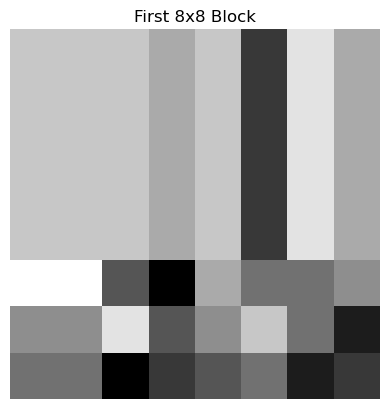

In [84]:
block_size = 8

h, w = Y.shape
H, W = -(-h // block_size) * block_size, -(-w // block_size) * block_size  

Y_padded = np.zeros((H, W), dtype=Y.dtype)
Y_padded[:h, :w] = Y

Y_blocks = Y_padded.reshape(H // block_size, block_size, W // block_size, block_size).swapaxes(1, 2)
first_block = Y_blocks[0, 0]

plt.imshow(first_block, cmap='gray')
plt.title("First 8x8 Block")
plt.axis('off')
plt.show()

### 6. Applying Discrete Cosine Transform (DCT) for an 8x8 block and visualizing coefficients.

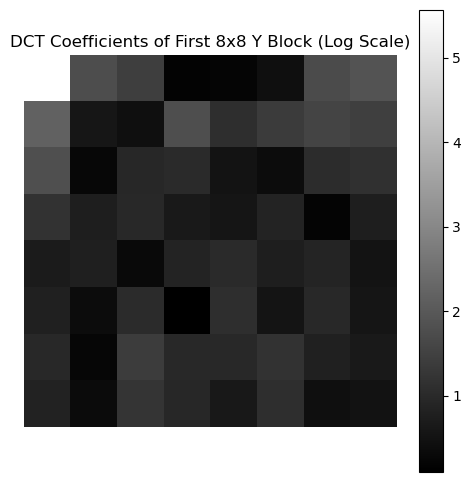

First 8x8 DCT Coefficients:
 [[259.5    4.77   3.24]
 [  7.95  -0.79   0.55]
 [ -5.03  -0.3   -1.55]]


In [85]:
dct_coefficients = dct2d(first_block)

plt.figure(figsize=(6, 6))
plt.imshow(np.log(abs(dct_coefficients) + 1), cmap='gray') 
plt.title('DCT Coefficients of First 8x8 Y Block (Log Scale)')
plt.colorbar()
plt.axis('off')
plt.show()

print("First 8x8 DCT Coefficients:\n", np.round(dct_coefficients[:3, :3], 2))

### 7. Quantization (Lossy Compression): Dividing the DCT coefficients by a quantization matrix (Q) and round values:

First 8x8 Quantized Coefficients:
 [[16.  0.  0.]
 [ 1. -0.  0.]
 [-0. -0. -0.]]


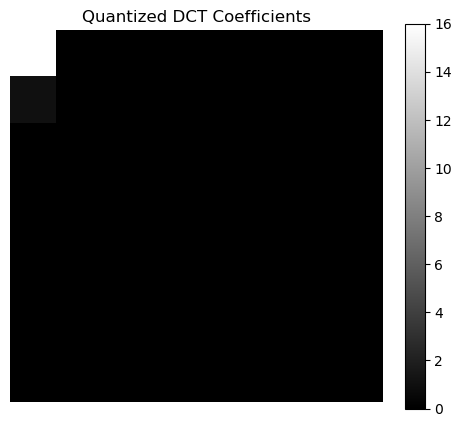

In [86]:
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

quantized_coeffs = np.round(dct_coefficients / Q)

print("First 8x8 Quantized Coefficients:\n", quantized_coeffs[:3, :3])

plt.figure(figsize=(6, 5))
plt.imshow(quantized_coeffs, cmap='gray')
plt.title('Quantized DCT Coefficients')
plt.colorbar()
plt.axis('off')
plt.show()


### 8. Dequantization and Reconstruction

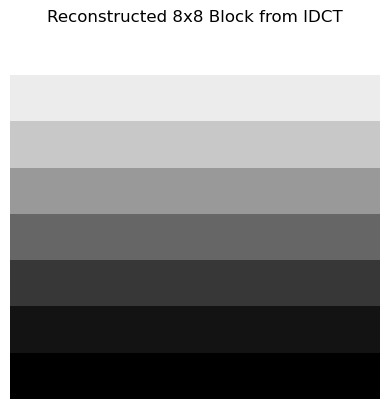

In [87]:
def idct2d(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho') + 128

if 'quantized_coeffs' in locals():
    dequantized = quantized_coeffs * Q
    reconstructed_block = idct2d(dequantized)

    plt.imshow(reconstructed_block, cmap='gray')
    plt.title("Reconstructed 8x8 Block from IDCT")
    plt.axis('off')
    plt.show()

### 9. Full Image Compression

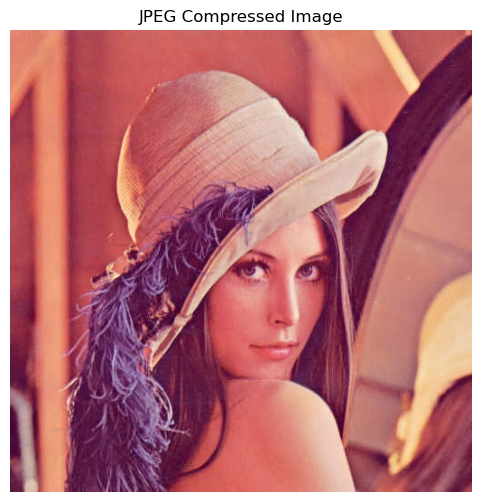

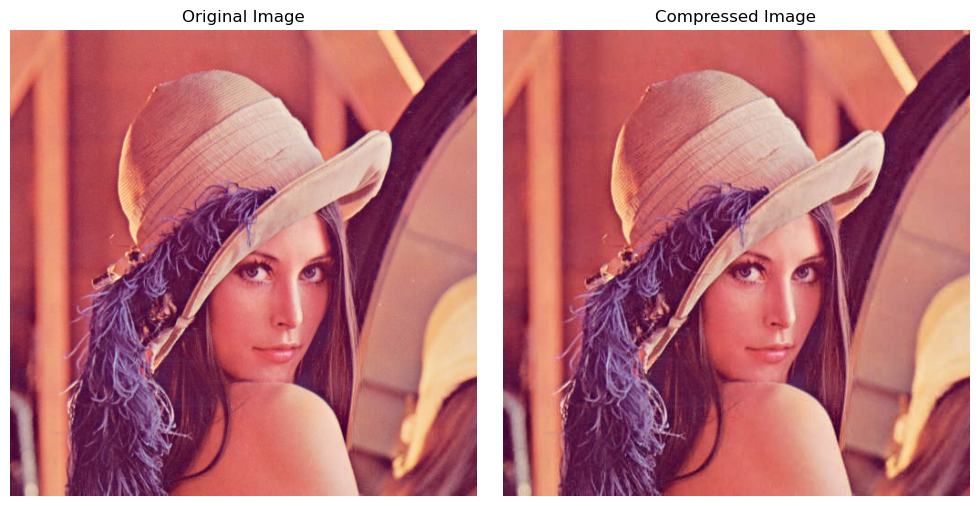

Original PNG file size: 508.92 KB
Compressed JPEG file size: 60.37 KB


In [88]:
def jpeg_compress(img, Q, subsample=True):
    img_ycbcr = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2YCrCb).astype(np.float32)
    Y, Cr, Cb = cv2.split(img_ycbcr)

    if subsample:
        Cb = chroma_subsample_420_avg(Cb)
        Cr = chroma_subsample_420_avg(Cr)
    
    def process_channel(channel):
        h, w = channel.shape
        H, W = -(-h // 8) * 8, -(-w // 8) * 8
        padded = np.zeros((H, W), dtype=np.float32)
        padded[:h, :w] = channel

        out = np.zeros_like(padded)
        for i in range(0, H, 8):
            for j in range(0, W, 8):
                block = padded[i:i+8, j:j+8] - 128
                dct_block = dct(dct(block.T, norm='ortho').T, norm='ortho')
                quant = np.round(dct_block / Q)
                dequant = quant * Q
                idct_block = idct(idct(dequant.T, norm='ortho').T, norm='ortho') + 128
                out[i:i+8, j:j+8] = np.clip(idct_block, 0, 255)

        return out[:h, :w]

    Y_compressed = process_channel(Y)
    if subsample:
        Cb = cv2.resize(Cb, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)
        Cr = cv2.resize(Cr, (Y.shape[1], Y.shape[0]), interpolation=cv2.INTER_LINEAR)

    Cb_compressed = process_channel(Cb)
    Cr_compressed = process_channel(Cr)

    compressed_ycbcr = cv2.merge([Y_compressed, Cr_compressed, Cb_compressed])
    compressed_rgb = cv2.cvtColor(compressed_ycbcr.astype(np.uint8), cv2.COLOR_YCrCb2RGB)

    return compressed_rgb


compressed_img = jpeg_compress(img, Q, subsample=True)

plt.figure(figsize=(6, 6))
plt.imshow(compressed_img)
plt.title("JPEG Compressed Image")
plt.axis('off')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img.astype(np.uint8))
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(compressed_img)
axes[1].set_title("Compressed Image")
axes[1].axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite("original.png", cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2.imwrite("compressed.jpg", cv2.cvtColor(compressed_img.astype(np.uint8), cv2.COLOR_RGB2BGR))

original_file_size = os.path.getsize("original.png") / 1024
compressed_file_size = os.path.getsize("compressed.jpg") / 1024

print(f"Original PNG file size: {original_file_size:.2f} KB")
print(f"Compressed JPEG file size: {compressed_file_size:.2f} KB")

### 10. PSNR Calculation

In [89]:
def psnr(original, compressed):
    mse = np.mean((original.astype(np.float64) - compressed.astype(np.float64)) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

psnr_value = psnr(img, compressed_img)
print(f"PSNR value: {psnr_value:.2f} dB")

PSNR value: 33.04 dB


### Bonus Task

PSNR (High Compression): 31.43 dB
PSNR (Low Compression): 34.27 dB


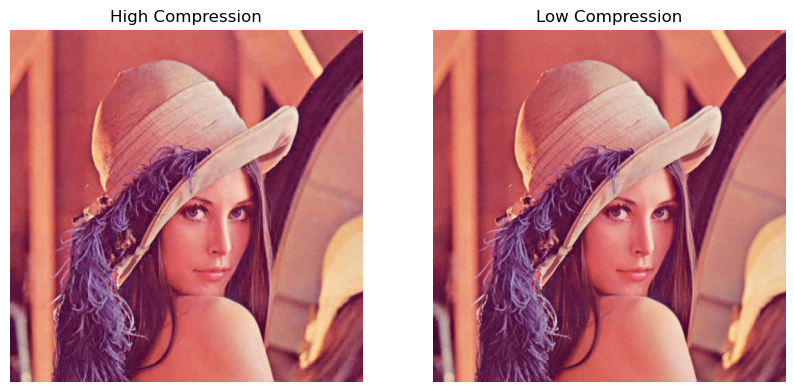

In [90]:
#  Different Q Matrices

Q_high_compression = Q * 2  
Q_low_compression = Q // 2 

compressed_high = jpeg_compress(img, Q_high_compression)
compressed_low = jpeg_compress(img, Q_low_compression)

psnr_high = psnr(img, compressed_high)
psnr_low = psnr(img, compressed_low)

print(f"PSNR (High Compression): {psnr_high:.2f} dB")
print(f"PSNR (Low Compression): {psnr_low:.2f} dB")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(compressed_high)
plt.title("High Compression")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed_low)
plt.title("Low Compression")
plt.axis('off')
plt.show()

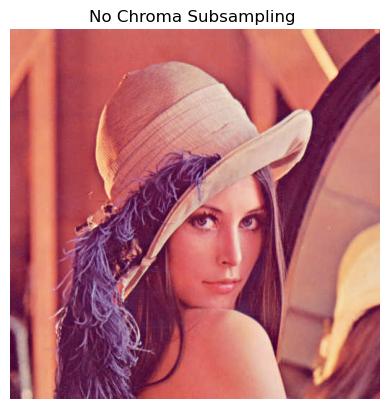

PSNR (No Chroma Subsampling): 33.31 dB


In [91]:
# Chroma Sub-sampling Disabled

compressed_no_subsample = jpeg_compress(img, Q, subsample=False)
psnr_nosub = psnr(img, compressed_no_subsample)

plt.imshow(compressed_no_subsample)
plt.title(f"No Chroma Subsampling ")
plt.axis('off')
plt.show()
print(f"PSNR (No Chroma Subsampling): {psnr_nosub:.2f} dB")

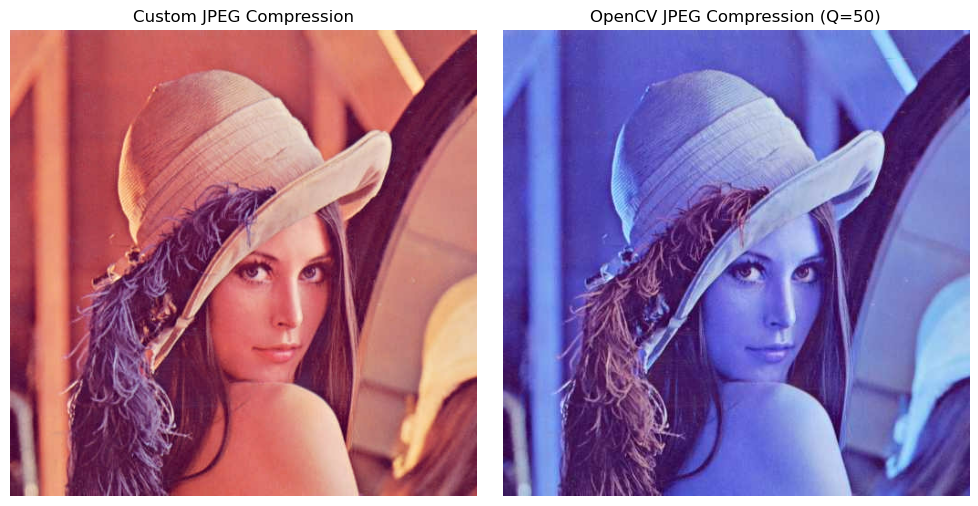

PSNR (Custom JPEG Compression): 33.04 dB
PSNR (OpenCV JPEG Compression): 11.53 dB


In [92]:
# Comparing with OpenCV’s JPEG Compression

_, encoded = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 50])
decoded = cv2.imdecode(encoded, cv2.IMREAD_COLOR)
decoded = cv2.cvtColor(decoded, cv2.COLOR_BGR2RGB)

psnr_opencv = psnr(img, decoded)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(compressed_img)
axes[0].set_title("Custom JPEG Compression")
axes[0].axis('off')

axes[1].imshow(decoded)
axes[1].set_title("OpenCV JPEG Compression (Q=50)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"PSNR (Custom JPEG Compression): {psnr(img, compressed_img):.2f} dB")
print(f"PSNR (OpenCV JPEG Compression): {psnr_opencv:.2f} dB")